<a href="https://colab.research.google.com/github/Brunorreis123/python/blob/main/Hackaton_Teros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo Teros

## Bibliotecas

In [ ]:
#Processamento de dados
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

#Modelos
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

#Acurácia
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix

#Gráficas
import seaborn as sns
import matplotlib.pyplot as plt

## Configurações Primárias

In [ ]:
pd.set_option('display.max_columns', 50)
SEED = 0
np.random.seed(SEED)

## Funções de Processamento de dados

In [ ]:
def abre_dados_modelo(path: str, coluna_y: str, colunas_utilizadas: list = None, **kwargs) -> tuple:
    dados: pd.DataFrame = pd.read_csv(path, **kwargs)
    if colunas_utilizadas is not None:
        dados = dados[colunas_utilizadas]
    y: pd.Series = dados[coluna_y]
    x: pd.DataFrame = dados.drop(columns=coluna_y)
    return x, y

def obtem_dummies_coluna(coluna_desejada: str, dataframe: pd.DataFrame) -> pd.DataFrame:
    dummies: pd.DataFrame = pd.get_dummies(dataframe[coluna_desejada]).copy()
    dataframe = pd.concat([dataframe, dummies], axis=1)
    dataframe = dataframe.drop(columns=coluna_desejada)
    return dataframe

def escala_dados(scaler, x: pd.DataFrame):
    scaler.fit(x)
    x_escalado = scaler.transform(x)
    return x_escalado

## Funções de Teste de Modelos

In [ ]:
def roda_teste_hiperparametros(x, y, modelo, cv, scaler = None, groups = None, **kwargs):
    SEED = 0
    np.random.seed(SEED)
    
    modelo_com_hiperparametros = modelo(**kwargs)
    if scaler is not None:
        x = escala_dados(scaler=scaler, x=x)
        
    resultado_cross_validate = cross_validate(
        modelo_com_hiperparametros, x, y, cv = cv, groups = groups, return_train_score = True
    )
    
    resultado_medio_teste = resultado_cross_validate['test_score'].mean()
    desvio_padrao_teste = resultado_cross_validate['test_score'].std()
    
    return resultado_medio_teste, desvio_padrao_teste

## Arquivos 

In [ ]:
colunas_selecionadas = [
    'Classificacao_da_Oportunidade', 'numero_relacionamentos_convertidos', 'Concorrentes', 
    'n_solucoes', 'Margem_Total', 'Custo_Total', 'Faixa_de_Faturamento_Agregado', 'id_fechou'
]
    
x, y = abre_dados_modelo(
    path='dados/dados_treino_hackaton.csv', 
    colunas_utilizadas=colunas_selecionadas, 
    coluna_y='id_fechou', encoding='latin1', sep=',', index_col=0
 )

colunas_dummies = ['Classificacao_da_Oportunidade', 'Faixa_de_Faturamento_Agregado']
for coluna in colunas_dummies:
    x = obtem_dummies_coluna(coluna, x)

### Resultado do DummyClassifier

In [ ]:
resultados_dummy_classifier = roda_teste_hiperparametros(
    x=x, y=y, scaler=MinMaxScaler(), modelo=DummyClassifier, 
    cv=StratifiedKFold(n_splits=10), 
)
print(f'Resultado DummyClassifier: {round(resultados_dummy_classifier[0], 5)}')
print(f'Desvio Padrão DummyClassifier: {round(resultados_dummy_classifier[1], 5)}')

Resultado DummyClassifier: 0.53181
Desvio Padrão DummyClassifier: 0.00679


## Testes

### Selecionando as melhores features e treinando o modelo

In [ ]:
x_escalado = escala_dados(scaler=MinMaxScaler(), x=x)
X_treino, X_teste, y_treino, y_teste = train_test_split(
    x_escalado, y, test_size=0.3, stratify=y, random_state=0
)

modelo = LogisticRegression(random_state = 0)
selecionador_RFECV = RFECV(modelo, cv = 7, scoring = 'accuracy')

selecionador_RFECV.fit(X_treino, y_treino)

treino_RFECV = selecionador_RFECV.transform(X_treino)
teste_RFECV = selecionador_RFECV.transform(X_teste)


modelo.fit(treino_RFECV, y_treino)
y_pred = modelo.predict(teste_RFECV)
print(f'Resultado LogisticRegression: {round(modelo.score(teste_RFECV, y_teste) * 100, 3)}%')
probabilidades = modelo.predict_proba(teste_RFECV)

Resultado LogisticRegression: 71.739%


### Matriz de Confusão

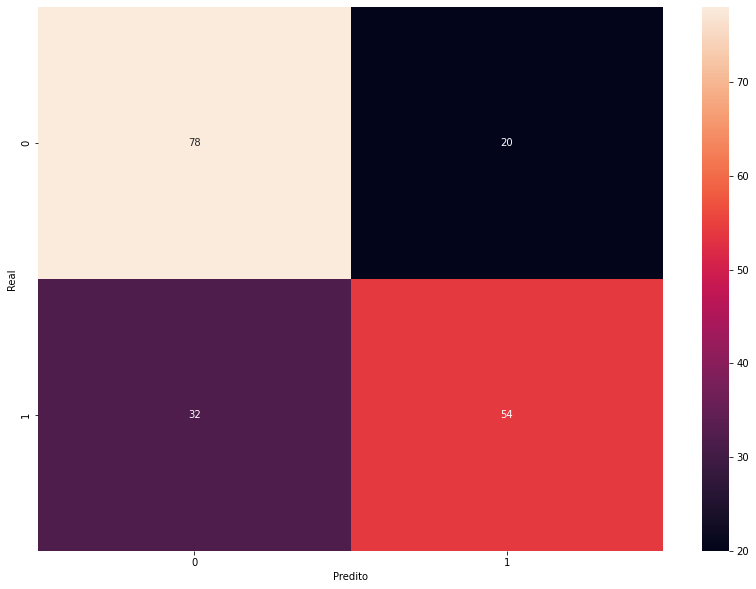

In [ ]:
matriz_confusao = confusion_matrix(y_teste, y_pred)
plt.figure(figsize = (14, 10))
ax = sns.heatmap(matriz_confusao, annot = True, fmt = 'd')
ax.set_xlabel('Predito', fontsize = 10)
ax.set_ylabel('Real', fontsize = 10)
ax = ax